추천을 위한 알고리즘을 분류해보면 크게 메모리 기반과 모델 기반으로 나눌 수 있다.

메모리 기반 추천 : 추천을 위한 데이터를 모두 메모리에 가지고 있으면서 추천이 필요할 때마다 이 데이터를 사용해서 계산을 해서 추천하는 방식  
모델 기반 추천 : 데이터로부터 추천을 위한 모델을 구성한 후 이 모델만 저장하고, 실제 추천을 할 때에는 이 모델을 사용해서 추천을 하는 방식

메모리 기반 추천은 원래 데이터를 충실하게 사용하는 장점이 있지만 대량의 데이터를 다뤄야 하는 상용 사이트에서 계신시간이 너무 오래걸린다는 단점이 있다.
<br/>
모델 기반 추천 방식은 데이터는 모형을 만드는 데만 사용하고 모델이 만들어지면 원래 데이터는 사용하지 않기 때문에 대규모 사용 사이트에서 필요한 빠른 반응이 가능하지만 모델을 만드는 과정에서 많은 계산이 필요하다.

일반적으로 메모리 기반 추천은 개별 사용자의 데이터에 집중하고, 모델 기반 추천은 전체 사용자의 평가 패턴으로부터 모델을 구성하기 때문에 데이터가 가지고 있는 약한 신호도 더 잘 잡아내는 장점이 있다.
<br/>
이번 장에서는 대표적인 모델 기반 추천 알고리즘인 MF 방식 추천에 대해 알아보기로 한다.

### 4.1 Matrix Factorization 방식의 원리

(사용자 X 아이템) 으로 구성된 하나의 행렬을 2개의 행렬로 분해하는 방법이다.  
앞서 CF 를 구현할 때 사용한 full matrix 는 (사용자 X 아이템) 형태의 2차원 행렬이다.  
이를 사용자 잠재요인행렬과 아이템 잠재요인행렬로 나눌 수 있다.

<img src = 'https://velog.velcdn.com/images/sangyun/post/07d390cb-b5b2-4ece-a095-b60a2805af8a/image.png' width = 600 height = 300>

R 행렬을 사용자행렬P와 아이템행렬Q로 쪼개어 분석하는 것이 MF 방식이다.  
P, Q 행렬에서 공통인 K개의 요인을 잠재요인으로 부르는데 사용자와 아이템의 특성을 K개의 잠재요인을 사용해서 분석하는 것이 MF 방식의 원리이다.

### 4.2 SGD를 사용한 MF 알고리즘

MF의 핵심은 주어진 사용자, 아이템의 관계를 가장 잘 설명하는 P, Q 행렬을 분해하는 것이다.  
주어진 (사용자X아이템) 평점 행렬인 R로부터 P,Q를 분해하는 알고리즘을 개념적으로 설명하면 다음과 같다.
1. 잠재요인의 개수 K를 정한다. K는 경험에 의한 직관적으로 정해도 되고, 다양한 K를 비교하면서 최적의 수를 정해도 된다.
2. 주어진 K에 따라 P, Q 행렬을 만들고 초기화한다.
3. 주어진 P,Q 행렬을 사용해 예측 평점을 구한다.
4. 실제 평점과 예측 평점을 비교해서 오차를 구하고, 이 오차를 줄이기 위해 P,Q 를 수정한다.
5. 전체 오차가 미리 정해진 기준값 이하가 되거나 미리 정해진 반복 횟수에 도달할 떄까지 3으로 돌아가서 반복한다.

여기서 핵심은 4에서 예측 오차를 줄이기 위해 어떻게 수정하는가이다.  
가장 일반적인 방법은 기계학습에서 많이 사용되는 SGD 방법을 적용하는 것이다.

SGD 방법을 적용하는 자세한 내용은 아래 링크 참조하자.  
https://bladejun.tistory.com/57

### 4.3 SGD를 사용한 MF 기본 알고리즘

In [1]:
import numpy as np
import pandas as pd

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./data/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

In [2]:
# MF class
class MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    def train(self): 
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # SGD for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            training_process.append((i+1, rmse))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f " % (i+1, rmse))
        return training_process

    # Rating prediction for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # SGD to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])


# 전체 데이터 사용 MF
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = MF(R_temp, K=30, alpha=0.01, beta=0.02, iterations=100, verbose=True)
train_process = mf.train()

Iteration: 10 ; Train RMSE = 0.8837 
Iteration: 20 ; Train RMSE = 0.7089 
Iteration: 30 ; Train RMSE = 0.5924 
Iteration: 40 ; Train RMSE = 0.5403 
Iteration: 50 ; Train RMSE = 0.5130 
Iteration: 60 ; Train RMSE = 0.4962 
Iteration: 70 ; Train RMSE = 0.4852 
Iteration: 80 ; Train RMSE = 0.4773 
Iteration: 90 ; Train RMSE = 0.4715 
Iteration: 100 ; Train RMSE = 0.4669 


결과가 좋게 나오는데 train/test set 을 나누지 않으므로 당연한 결과라고 할 수 있다.

### 4.4 train test 분리 MF 알고리즘

3장의 CF 와 마찬가지로 train/test set 분리하여 훈련한다.  
차이점은 3장의 CF는 sklearn의 train_test_split 을 사용했는데 여기서는 sklearn 의 shuffle을 사용한다.  
3장에서는 층화추출을 할 수 있지만 여기서는 무작위로 섞기 때문에 극단적인 경우 특정 사용자의 모든 데이터가 train이나 test set 한 곳에 들어갈 수 있다.  
어떤 것을 사용할 지는 데이터분석의 목적에 따라서 선택하면 된다.

In [4]:
# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state=42)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [16]:
# New MF class for training & testing
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose = True):
        self.R = np.array(ratings)
        # user_id, item_id를 R의 index 와 매핑하기 위한 dictionary 생성
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_id_item = dict(index_item_id)
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)

        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # train set 의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x,y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x,y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))
        
    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    # SGD to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    
    # Test set 을 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)): # test 데이터에 있는 각 데이터에 대해서
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            z = ratings_test.iloc[i, 2]
            test_set.append([x,y,z])
            self.R[x,y] = 0 # setting test set ratings to 0
        self.test_set = test_set
        return test_set # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error / len(self.test_set))
    
    # Training 하면서 test set 의 정확도를 계산
    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)

In [17]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()

Iteration: 10 ; Train RMSE = 0.9678 ; Test RMSE = 0.9781
Iteration: 20 ; Train RMSE = 0.9426 ; Test RMSE = 0.9588
Iteration: 30 ; Train RMSE = 0.9311 ; Test RMSE = 0.9512
Iteration: 40 ; Train RMSE = 0.9242 ; Test RMSE = 0.9474
Iteration: 50 ; Train RMSE = 0.9192 ; Test RMSE = 0.9452
Iteration: 60 ; Train RMSE = 0.9152 ; Test RMSE = 0.9438
Iteration: 70 ; Train RMSE = 0.9114 ; Test RMSE = 0.9427
Iteration: 80 ; Train RMSE = 0.9072 ; Test RMSE = 0.9417
Iteration: 90 ; Train RMSE = 0.9022 ; Test RMSE = 0.9405
Iteration: 100 ; Train RMSE = 0.8957 ; Test RMSE = 0.9389


In [18]:
# Printing predictions
print(mf.full_prediction())
print()
print(mf.get_one_prediction(1, 2))

[[3.83665804 3.33239295 3.21311212 ... 3.40627265 3.48089157 3.51967726]
 [4.02409366 3.51583752 3.31831102 ... 3.50442026 3.6210149  3.61919936]
 [3.25771844 2.71172472 2.51663725 ... 2.72739058 2.83967058 2.8385036 ]
 ...
 [4.2647238  3.70848446 3.50990559 ... 3.70895564 3.84126338 3.82485628]
 [4.41500302 3.88447175 3.68602581 ... 3.90041141 4.01516739 4.01293757]
 [3.73420802 3.29681902 3.07985555 ... 3.25602468 3.36415046 3.36816193]]

3.3323929457051373


연습문제
1. shuffle() 대신 train_test_split 을 사용하여 분리하도록 수정하고 실행해보자.
2. 실행결과에서 RMSE가 많이 차이난다면 왜 차이가 발생했을 지 설명해보자.

In [9]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./data/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

In [11]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.25, random_state=42)

,user_id,movie_id,rating
75721,877,381,4
80184,815,602,3
19864,94,431,4
76699,416,875,2
92991,500,182,2
...,...,...,...
21271,399,684,3
34014,222,580,3
81355,551,162,5
65720,803,988,1


In [12]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()

Iteration: 10 ; Train RMSE = 0.9678 ; Test RMSE = 0.9780
Iteration: 20 ; Train RMSE = 0.9426 ; Test RMSE = 0.9587
Iteration: 30 ; Train RMSE = 0.9311 ; Test RMSE = 0.9511
Iteration: 40 ; Train RMSE = 0.9242 ; Test RMSE = 0.9472
Iteration: 50 ; Train RMSE = 0.9192 ; Test RMSE = 0.9450
Iteration: 60 ; Train RMSE = 0.9151 ; Test RMSE = 0.9434
Iteration: 70 ; Train RMSE = 0.9111 ; Test RMSE = 0.9422
Iteration: 80 ; Train RMSE = 0.9066 ; Test RMSE = 0.9410
Iteration: 90 ; Train RMSE = 0.9011 ; Test RMSE = 0.9394
Iteration: 100 ; Train RMSE = 0.8939 ; Test RMSE = 0.9374


### 4.5 MF의 최적 파라미터 찾기

K, iteratinos, $\alpha$, $\beta$ 와 같은 파라미터가 정확도에 영향을 미친다.  
잠재요인의 수인 K의 경우 커질수록 다양한 패턴을 학습할 수 있으므로 정확도가 높아지는데, 지나치게 커지면 과적합이 발생한다.  
따라서 K가 커짐에 따라 test set 의 정확도가 커지다가 감소하는 모습을 예상할 수 있다.

iterations 도 마찬가지 현상이 발생한다. 즉 최적의 파라미터를 찾는게 중요하다.

이 장에서는 다음과 같은 절차로 최적값을 찾아보도록 한다.
1. 최적의 K가 대략 어떤 수인지 확인하기 위해 50~260까지 간격 10으로 정확도를 계산한다.
2. 최적의 RMSE를 보이는 K를 확인한 후 이 숫자 전후 10의 K에 대해 1의 간격으로 다시 한번 RMSE를 계산하여 K를 찾는다.
3. iterations 는 학습 과정에서 충분히 큰 숫자를 주어서 RMSE가 어떻게 변화하는지 관찰해서 주어진 K에 대해 최적의 iteration 값을 구한다.

In [23]:
# 최적의 K값 찾기
results = []
index = []
for K in range(50, 261, 10):
    print('K =', K)
    R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    mf = NEW_MF(R_temp, K=K, alpha=0.001, beta=0.02, iterations=100, verbose=True)
    test_set = mf.set_test(ratings_test)
    result = mf.test()
    index.append(K)
    results.append(result)

K = 50
Iteration: 10 ; Train RMSE = 0.9680 ; Test RMSE = 0.9780
Iteration: 20 ; Train RMSE = 0.9431 ; Test RMSE = 0.9587
Iteration: 30 ; Train RMSE = 0.9318 ; Test RMSE = 0.9512
Iteration: 40 ; Train RMSE = 0.9252 ; Test RMSE = 0.9474
Iteration: 50 ; Train RMSE = 0.9206 ; Test RMSE = 0.9452
K = 60
Iteration: 10 ; Train RMSE = 0.9681 ; Test RMSE = 0.9780
Iteration: 20 ; Train RMSE = 0.9432 ; Test RMSE = 0.9587
Iteration: 30 ; Train RMSE = 0.9320 ; Test RMSE = 0.9512
Iteration: 40 ; Train RMSE = 0.9254 ; Test RMSE = 0.9473
Iteration: 50 ; Train RMSE = 0.9210 ; Test RMSE = 0.9451
K = 70
Iteration: 10 ; Train RMSE = 0.9681 ; Test RMSE = 0.9780
Iteration: 20 ; Train RMSE = 0.9433 ; Test RMSE = 0.9587
Iteration: 30 ; Train RMSE = 0.9322 ; Test RMSE = 0.9512
Iteration: 40 ; Train RMSE = 0.9256 ; Test RMSE = 0.9473
Iteration: 50 ; Train RMSE = 0.9212 ; Test RMSE = 0.9452
K = 80
Iteration: 10 ; Train RMSE = 0.9682 ; Test RMSE = 0.9780
Iteration: 20 ; Train RMSE = 0.9434 ; Test RMSE = 0.9587
Ite

In [25]:
# 최적의 iterations 값 찾기
summary = []
for i in range(len(results)):
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min)
    summary.append([index[i], j+1, RMSE[j]])

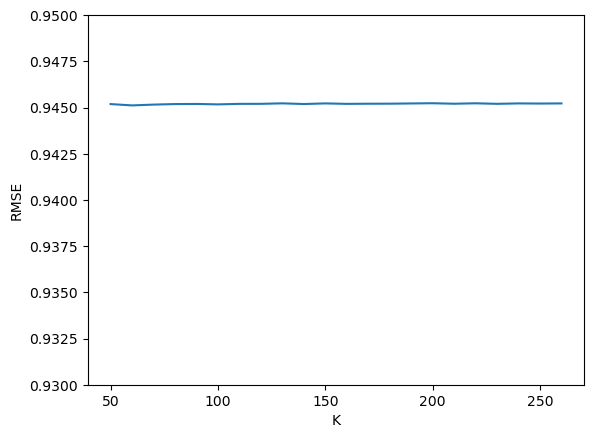

In [37]:
# 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(index, [x[2] for x in summary])
plt.ylim(0.93, 0.95)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

같은 방법으로 $\alpha, \beta$ 에서도 최적값을 구할 수 있다.